## CRISP-DM (https://www.datascience-pm.com/crisp-dm-2/)

- 1. Business Understanding
- 2. Data Understanding
- 3. Data Preparation
- 4. Modeling
- 5. Evaluation
- 6. Deployment

### 1. Business Understanding - Jonnas

- 1.1. Determine business objectives
- 1.2. Assess situation
- 1.3. Determine data mining goals
- 1.4. Produce project plan

Isto deve ser so teorico

### 2. Data Understanding - Vicente

- 2.1. Collect initial data - ler os dados todos
- 2.2. Describe data - examinar os dados e descreve-los, as suas propriedades, numero de ocorrencia, etc.
- 2.3. Explore data - explorar os dados, visualizalos, ver padroes, etc.
- 2.4. Verify data quality - verificar a integridade dos dados, ver se tem erros, inconsistencias, etc.

In [124]:
import csv                              #-----------------------------#
import random                           #    READING THE DATASET      #
import numpy as np                      #-----------------------------#
import pandas as pd

# 2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.

def read_and_truncate_dataset(file_path_1="dataset.csv", file_path_2="./FinalProject/dataset.csv", percentagem_da_dataset_a_usar=100):
    """
    Retorna um numpy array de arrays com o dataset da mesma forma que está no csv. Retorna também um panda dataframe

    Controla a quantidade de dados a usar da dataset original com percentagem_da_dataset_a_usar. 3.24 ~= 10000 linhas do csv original
    """
    try:
        with open(file_path_1, mode='r') as file:
            csvFile = csv.reader(file)
            categorias = next(csvFile)
        dadosC = pd.read_csv(file_path_1)
    except FileNotFoundError:
        with open(file_path_2, mode='r') as file:
            csvFile = csv.reader(file)
            categorias = next(csvFile)
        dadosC = pd.read_csv(file_path_2)
    
    # Truncate dataset
    num_rows_to_use = int(len(dadosC) * (percentagem_da_dataset_a_usar / 100))
    truncated_dadosC = dadosC.head(num_rows_to_use)

    # Convert to NumPy array
    numpy_array = truncated_dadosC.to_numpy()

    # Return both NumPy array, Pandas DataFrame, and column names
    return numpy_array, truncated_dadosC, categorias

numpy_arrays_dataset, pandas_frame_dataset, categorias = read_and_truncate_dataset(percentagem_da_dataset_a_usar=0.5) # para testes e desenvolvimento

numpy_arrays_dataset_transposed = numpy_arrays_dataset.T

Tipos de respostas para a categoria General_Health:
['Excellent' 'Fair' 'Good' 'Poor' 'Very Good']

Tipos de respostas para a categoria Checkup:
['5 or more years ago' 'Never' 'Within the past 2 years'
 'Within the past 5 years' 'Within the past year']

Tipos de respostas para a categoria Exercise:
['No' 'Yes']

Tipos de respostas para a categoria Heart_Disease:
['No' 'Yes']

Tipos de respostas para a categoria Skin_Cancer:
['No' 'Yes']

Tipos de respostas para a categoria Other_Cancer:
['No' 'Yes']

Tipos de respostas para a categoria Depression:
['No' 'Yes']

Tipos de respostas para a categoria Diabetes:
['No' 'No, pre-diabetes or borderline diabetes' 'Yes'
 'Yes, but female told only during pregnancy']

Tipos de respostas para a categoria Arthritis:
['No' 'Yes']

Tipos de respostas para a categoria Sex:
['Female' 'Male']

Tipos de respostas para a categoria Age_Category:
['18-24' '25-29' '30-34' '35-39' '40-44' '45-49' '50-54' '55-59' '60-64'
 '65-69' '70-74' '75-79' '80+']

Tipos d

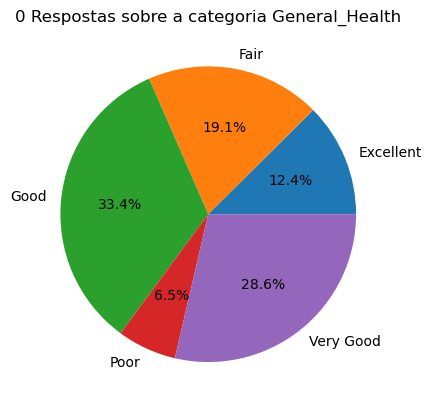

['5 or more years ago' 'Never' 'Within the past 2 years'
 'Within the past 5 years' 'Within the past year']
[45, 5, 143, 41, 1310]


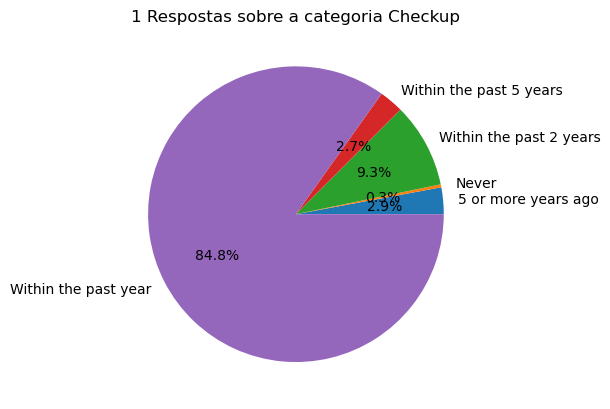

['No' 'Yes']
[598, 946]


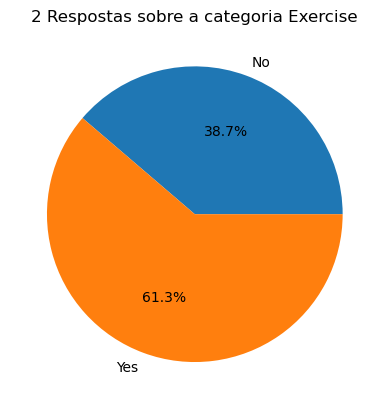

['No' 'Yes']
[1350, 194]


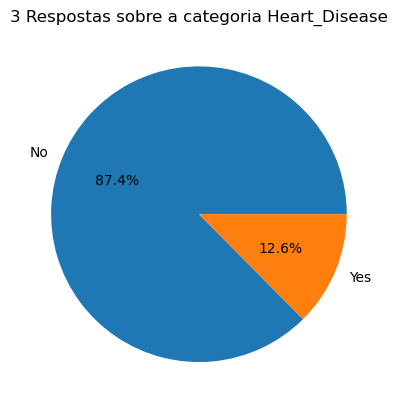

['No' 'Yes']
[1318, 226]


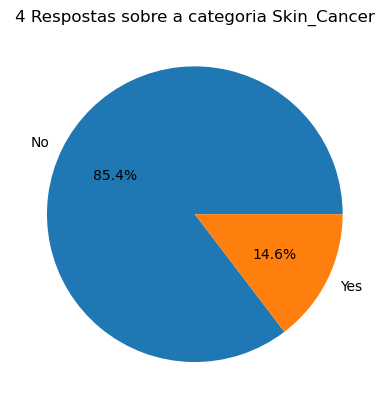

['No' 'Yes']
[1348, 196]


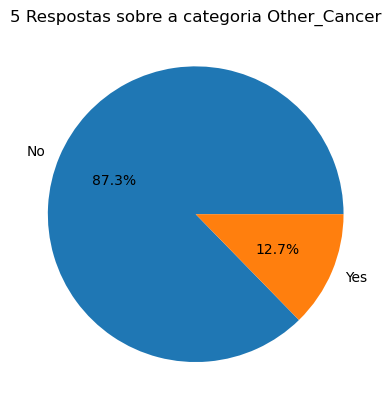

['No' 'Yes']
[1262, 282]


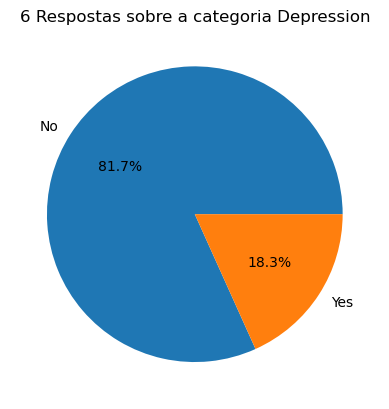

['No' 'No, pre-diabetes or borderline diabetes' 'Yes'
 'Yes, but female told only during pregnancy']
[1181, 25, 330, 8]


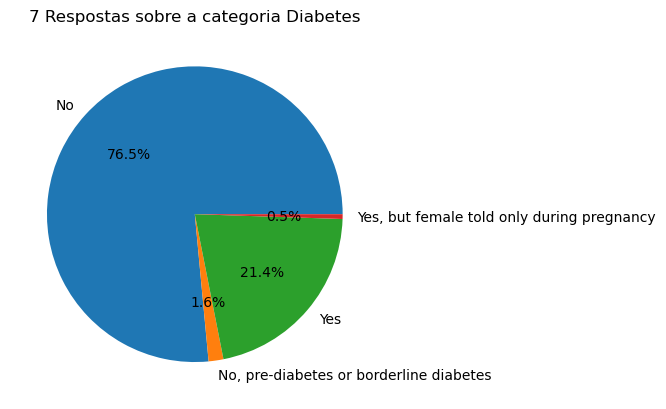

['No' 'Yes']
[812, 732]


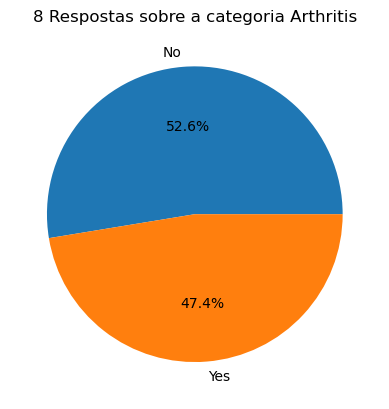

['Female' 'Male']
[992, 552]


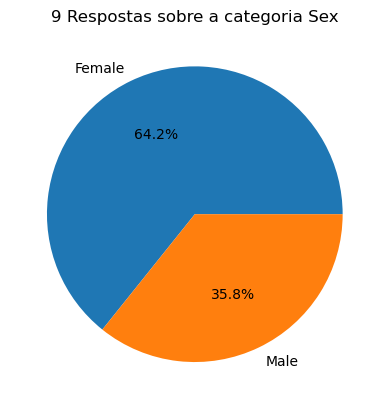

['18-24' '25-29' '30-34' '35-39' '40-44' '45-49' '50-54' '55-59' '60-64'
 '65-69' '70-74' '75-79' '80+']
[44, 38, 63, 53, 76, 72, 81, 115, 190, 208, 248, 159, 197]


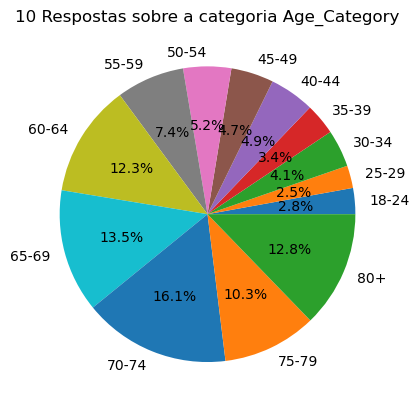

[135.0 140.0 142.0 145.0 147.0 150.0 152.0 155.0 157.0 160.0 163.0 165.0
 168.0 170.0 173.0 175.0 178.0 180.0 183.0 185.0 188.0 191.0 193.0 196.0
 198.0 206.0]
[1, 1, 1, 2, 2, 17, 56, 55, 117, 124, 167, 136, 148, 114, 97, 104, 91, 81, 82, 57, 40, 25, 13, 7, 5, 1]


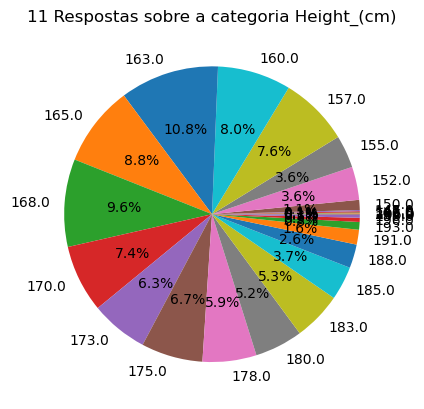

[32.66 33.11 34.02 40.82 42.64 43.09 44.45 44.91 45.36 45.81 46.27 46.72
 47.63 48.53 48.99 49.44 49.9 50.8 51.26 51.71 52.16 52.62 53.07 53.52
 54.43 54.88 55.34 55.79 56.25 56.7 57.15 57.61 58.06 58.51 58.97 59.87
 60.33 60.78 61.23 61.69 62.14 62.6 63.05 63.5 63.96 64.41 64.86 65.32
 65.77 66.22 66.68 67.13 67.59 68.04 68.49 68.95 69.4 69.85 70.31 70.76
 71.21 71.67 72.12 72.57 73.03 73.48 73.94 74.39 74.84 75.3 75.75 76.2
 76.66 77.11 77.56 78.02 78.47 78.93 79.38 79.83 80.29 80.74 81.19 81.65
 82.1 82.55 83.01 83.46 83.91 84.37 84.82 85.28 85.73 86.18 86.64 87.09
 87.54 88.0 88.45 88.9 89.36 89.81 90.26 90.72 91.17 91.63 92.08 92.53
 92.99 93.44 93.89 94.35 94.8 95.25 95.71 96.16 96.62 97.07 97.52 97.98
 98.43 98.88 99.34 99.79 101.15 101.6 102.06 102.51 102.97 103.42 103.87
 104.33 105.23 105.69 106.14 106.59 107.05 107.5 107.95 108.41 108.86
 109.77 110.22 110.68 111.13 111.58 112.04 112.49 113.4 114.31 114.76
 115.67 116.12 117.03 117.48 117.93 118.39 119.29 119.75 120.2 120.66

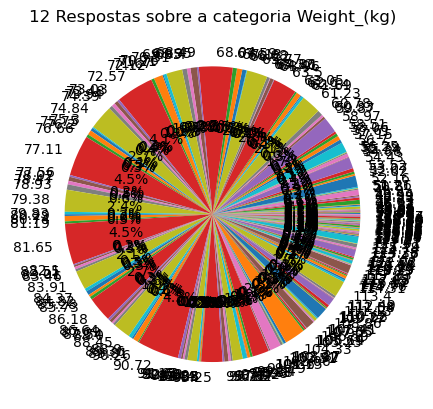

[14.06 14.54 15.82 16.04 16.23 16.54 16.62 16.64 16.73 17.23 17.38 17.47
 17.54 17.58 17.75 17.76 17.79 17.81 17.91 18.01 18.02 18.04 18.07 18.24
 18.27 18.29 18.31 18.56 18.69 18.71 18.72 18.75 18.79 18.88 18.89 18.95
 19.13 19.14 19.2 19.26 19.27 19.37 19.47 19.53 19.57 19.67 19.74 19.77
 19.8 19.84 19.87 19.94 19.97 20.0 20.05 20.07 20.08 20.09 20.12 20.18
 20.2 20.22 20.25 20.34 20.36 20.37 20.38 20.4 20.48 20.5 20.51 20.53 20.6
 20.62 20.63 20.64 20.78 20.8 20.82 20.83 20.85 20.92 20.98 21.03 21.09
 21.11 21.13 21.14 21.18 21.21 21.22 21.24 21.26 21.29 21.4 21.41 21.46
 21.52 21.58 21.61 21.63 21.7 21.79 21.8 21.81 21.83 21.86 21.87 21.89
 21.91 21.93 21.95 21.97 22.0 22.04 22.14 22.15 22.24 22.26 22.3 22.31
 22.32 22.36 22.38 22.4 22.43 22.45 22.46 22.5 22.53 22.6 22.63 22.65
 22.66 22.67 22.71 22.74 22.81 22.86 22.87 22.89 22.92 22.96 23.0 23.01
 23.03 23.04 23.05 23.06 23.11 23.13 23.17 23.26 23.3 23.33 23.34 23.37
 23.39 23.4 23.41 23.44 23.46 23.48 23.49 23.52 23.53 23.56 23.

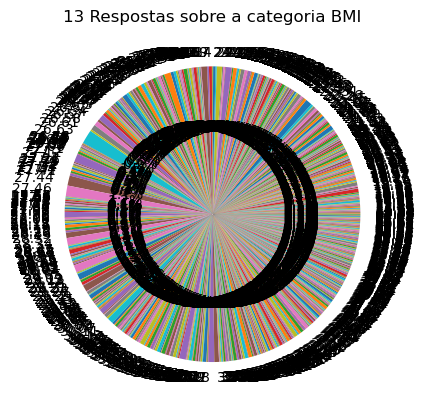

['No' 'Yes']
[920, 624]


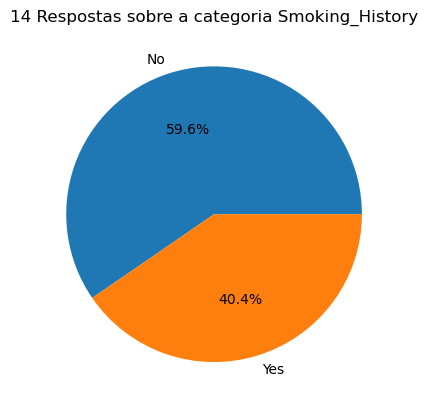

[0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 15.0 16.0 17.0
 20.0 24.0 25.0 28.0 29.0 30.0]
[1028, 85, 72, 37, 64, 24, 10, 8, 39, 2, 27, 1, 26, 17, 11, 1, 26, 1, 6, 12, 1, 46]


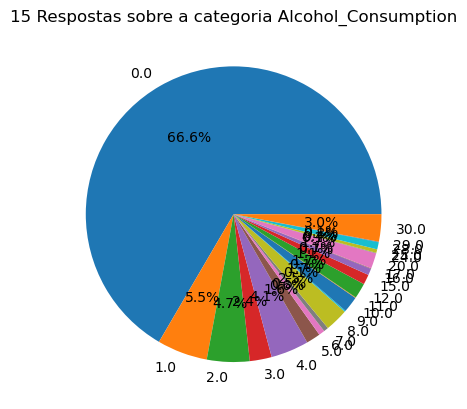

[0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 10.0 12.0 14.0 15.0 16.0 20.0 24.0
 25.0 28.0 30.0 32.0 40.0 60.0 80.0 90.0 120.0]
[45, 33, 60, 29, 78, 23, 9, 4, 150, 23, 160, 1, 15, 90, 58, 11, 5, 21, 506, 1, 1, 147, 1, 66, 7]


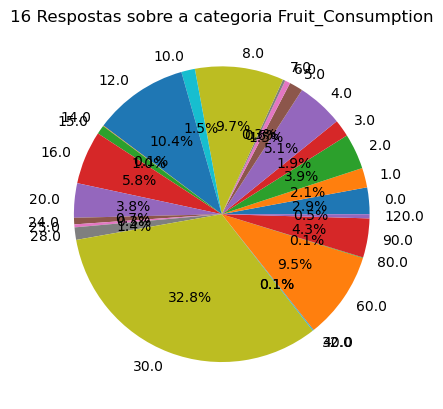

[0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0
 17.0 18.0 19.0 20.0 22.0 24.0 25.0 27.0 28.0 30.0 40.0 56.0 60.0 80.0
 90.0 120.0]
[131, 55, 82, 34, 229, 38, 14, 8, 240, 28, 1, 218, 1, 1, 30, 105, 1, 1, 1, 83, 1, 8, 6, 1, 14, 178, 3, 1, 23, 1, 5, 2]


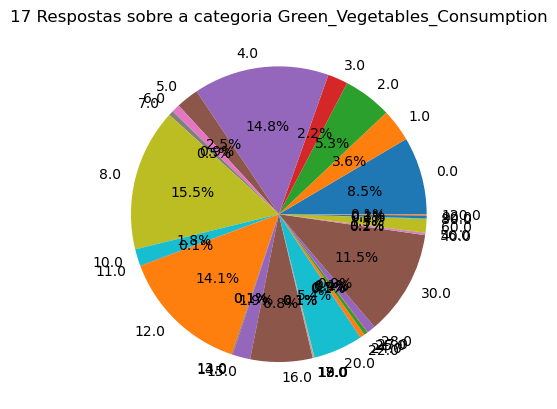

[0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 12.0 14.0 15.0 16.0 20.0
 21.0 24.0 25.0 28.0 30.0 32.0 33.0 48.0 60.0 90.0 120.0]
[276, 155, 168, 68, 331, 32, 9, 11, 195, 2, 31, 104, 3, 24, 42, 25, 1, 3, 1, 6, 45, 1, 1, 1, 7, 1, 1]


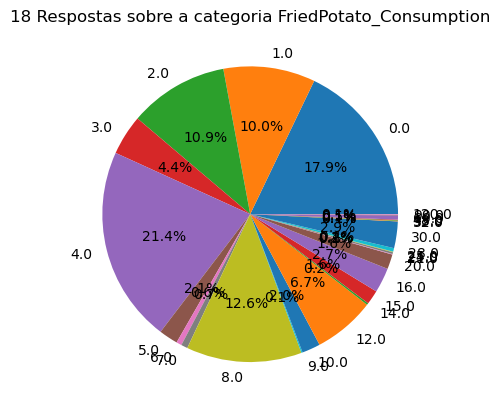

'\nfor i in numpy_arrays_dataset_transposed:\n    print(len(i))\nprint(len(numpy_arrays_dataset_transposed.T))\n'

In [125]:
import matplotlib.pyplot as plt

# 2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.

# exemplos do dataset
'''
for i in range(len(categorias)):
    print("Categoria "+str(categorias[i])+":")
    print(numpy_arrays_dataset_transposed[i,0:5],end="\n\n")
'''

# tipos de diferentes respostas a cada categoria
for i in range(len(categorias)):
    print("Tipos de respostas para a categoria "+str(categorias[i])+":")
    print(np.unique(numpy_arrays_dataset_transposed[i]),end="\n\n")



# graficos para respostas
count = 0
for i in numpy_arrays_dataset_transposed:
	unicos = np.unique(i)
	valores = [np.count_nonzero(i==x) for x in unicos]
    
	print(unicos)
	print(valores)

	plt.title(str(count)+" Respostas sobre a categoria "+str(categorias[count]))
	plt.pie(valores,labels=unicos,autopct='%1.1f%%')
	plt.show()
	count+=1 


# pessoas que dizem que n fazem exercicio -> +% na parte de doencas
'''
indices = []
for i in range(len(numpy_arrays_dataset_transposed[2])):
    #3 4 5 6 7 8
    if numpy_arrays_dataset_transposed[2][i] == "No":
        indices.append(i)

for i in range(3,9):
	unicos = np.unique(numpy_arrays_dataset_transposed[i])
	valores = [str(numpy_arrays_dataset_transposed[i][j]) for j in indices]
	valores = np.array(valores)
	valores2 = [np.count_nonzero(valores==x) for x in unicos]
    
	plt.title("Respostas para pessoas que nao fazem exercicio para a categoria "+str(categorias[i]))
	plt.pie(valores2,labels=unicos,autopct='%1.1f%%')
	plt.show()
'''


# ver que respostas deram as pessoas que tem problemas cardiacos
'''
indices = []
for i in range(len(numpy_arrays_dataset_transposed[3])):
    if numpy_arrays_dataset_transposed[3][i] == "Yes":
        indices.append(i)

for i in range(len(categorias)):
	unicos = np.unique(numpy_arrays_dataset_transposed[i])
	valores = [str(numpy_arrays_dataset_transposed[i][j]) for j in indices]
	valores = np.array(valores)
	valores2 = [np.count_nonzero(valores==x) for x in unicos]
    
	plt.title("Respostas para pessoas que têm doenças cardiacas para a categoria "+str(categorias[i]))
	plt.pie(valores2,labels=unicos,autopct='%1.1f%%')
	plt.show()
'''

# 2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.

# falar da inconsistencia das batatas fritas / alcool / fruta / vegetais
# vou usar quantas vezes por mes come/bete a categoria

# mostrar que nao tem valores em falta
'''
for i in numpy_arrays_dataset_transposed:
    print(len(i))
print(len(numpy_arrays_dataset_transposed.T))
'''

### 3. Data Preparation

- 3.1. Select data - Determine which data sets will be used and document reasons for inclusion/exclusion.
- 3.2. Clean data - Often this is the lengthiest task. Without it, you’ll likely fall victim to garbage-in, garbage-out. A common practice during this task is to correct, impute, or remove erroneous values.
- 3.3. Construct data - Derive new attributes that will be helpful. For example, derive someone’s body mass index from height and weight fields.
- 3.4. Integrate data - Create new data sets by combining data from multiple sources.
- 3.5. Format data - Re-format data as necessary. For example, you might convert string values that store numbers to numeric values so that you can perform mathematical operations.

Esta parte vai ser para a parte de alterar o dataset que o stor disse, depois temos de incluir estes topicos talvez

###### - Randomly remove 10% and 20% of the values of the features the dataset and explore two different strategies to handle missing values;
###### - Experiment with data normalization, data discretization, and data reduction. Apply these steps to the original, unchanged, dataset.

#### Strategies to handle missing values

Para poder testar vários métodos para lidar com "missing values", temos primeiro que gerar uma database com missing values, para simular isto, a função a baixo remove aleatoreamente uma percentagem de datapoints da dataset e substitui por None, ficando da forma do seguinte exemplo:

| Health | Checkup           | Exer | HD | SC | OC | D | Di | A | Sex    | Age | cm | kg | BMI   | SH | AC | FC | GVC | FPC |
|-----------------|-------------------------|----------|---------------|-------------|--------------|------------|----------|-----------|--------|--------------|-------------|-------------|-------|-----------------|---------------------|-------------------|-----------------------------|-------------------------|
| Poor           | Within the past 2 years | No       | None          | No          | No           | No         | No       | Yes       | None   | 70-74        | None        | 32.66       | None  | Yes             | 0.0                 | 30.0             | None                       | 12.0                   |
| None           | Within the past year    | None     | Yes           | No          | None         | No         | Yes      | None      | Female | None         | 165.0       | None        | 28.29 | No              | 0.0                 | 30.0             | 0.0                        | None                   |
| Very Good      | Within the past year    | Yes      | None          | No          | None         | No         | None     | No        | Female | 60-64        | 163.0       | 88.45       | None  | No              | 4.0                 | None             | 3.0                        | None                   |
| Poor           | None                    | Yes      | Yes           | None        | No           | No         | Yes      | None      | Male   | 75-79        | None        | None        | 28.73 | No              | None                | 30.0             | 30.0                       | 8.0                    |


In [126]:
import random
import pandas as pd
import numpy as np

def damage_dataset(percentage, dataset):
    """
        Pode receber dataset em numpy form, mas retorna sempre em Panda Dataframe, substitui 20% dos dataponts por None
    """
    # I want a pandas DataFrame
    if isinstance(dataset, np.ndarray):
        dataset = pd.DataFrame(dataset)
    elif not isinstance(dataset, pd.DataFrame):
        raise ValueError("Input dataset must be either a pandas DataFrame or a NumPy array.")

    num_elements = dataset.size # numero de elementos do dataset
    
    num_to_damage = int(num_elements * percentage) # num de elementos a danificar
    
    row_indices, col_indices = dataset.shape
    for _ in range(num_to_damage):
        rand_row = random.randint(0, row_indices - 1)
        rand_col = random.randint(0, col_indices - 1)
        dataset.iat[rand_row, rand_col] = None

    return dataset


In [127]:
from collections import Counter						#---------------------------------#
from sklearn.preprocessing import LabelEncoder		#      Handle Missing Values      #
													#---------------------------------#

# Metodo extra - apagar os dados

copia = numpy_arrays_dataset_transposed.copy()
testes = damage_dataset(0.2,copia) # dataset com None
testes = testes.to_numpy() # queres um numpy array
ok = 0
for i in testes[0]:
	if i == "None":
		ok+=1
print("Nones testes[0] "+str(ok))
print("len() testes[0] "+str(len(testes[0])))


# METODO 1 - Vicente, substituir pelo valor mais frequente

# Pega no dataset com Nones e substitui-os pelo valor mais frequente da categoria
def mais_freq(dataset):
    if isinstance(dataset, pd.DataFrame):
        dataset = dataset.to_numpy()
    dataset = dataset.T

    dataset = dataset.tolist()  # É mais rápido se for lista normal em vez de np.array (não sei porque)
    maxx = []
    for i in range(len(dataset)):  # VER O BMI
        conta = Counter(dataset[i])
        del conta["None"]
        # print(conta.most_common(1))
        maxx.append(conta.most_common(1))

    # print(maxx)
    # print(maxx[0])
    # print(maxx[0][0][0])

    for i in range(len(dataset)):
        for j in range(len(dataset[i])):
            if dataset[i][j] == "None":
                dataset[i][j] = maxx[i][0][0]

    # Convert back to NumPy array
    dataset_np = np.array(dataset).T

    return dataset_np  # TODO, devia retornar panda frame

testes2 = mais_freq(testes) # dataset com None substituido por mais frequente
ok2 = 0
for i in testes2[0]:
	if i == "None":
		ok2+=1
print("Nones testes2[0] "+str(ok2))
print("len() testes2[0] "+str(len(testes2[0])))

Nones testes[0] 0
len() testes[0] 1544
Nones testes2[0] 0
len() testes2[0] 1544


In [128]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

def remove_lines_with_missing_values(dataset):
    if isinstance(dataset, np.ndarray):
        dataset = pd.DataFrame(dataset)
    elif not isinstance(dataset, pd.DataFrame):
        raise ValueError("Input dataset must be either a pandas DataFrame or a NumPy array.")

    initial_rows = len(dataset)
    cleaned_dataset = dataset.dropna()
    final_rows = len(cleaned_dataset)
    removed_percentage = ((initial_rows - final_rows) / initial_rows) * 100

    print(f"[REMOVE_LINES_WITH_MISSING_VALUES]: Percentage of rows removed: {removed_percentage:.2f}%")
    return cleaned_dataset

def fill_missing_values_with_mean_and_mode(dataset):
    """
    Usa a média para preencher valores númericos em falta
    Usa a moda para preencher valores categoricos em falta
    """
    if isinstance(dataset, np.ndarray):
        dataset = pd.DataFrame(dataset)
    elif not isinstance(dataset, pd.DataFrame):
        raise ValueError("Input dataset must be either a pandas DataFrame or a NumPy array.")

    for column in dataset.columns:
        if dataset[column].dtype in ['float64', 'int64']:  # valores numericos
            mean_value = dataset[column].mean()
            dataset[column].fillna(mean_value, inplace=True)
        else:  # Categorical column
            mode_value = dataset[column].mode()[0]
            dataset[column].fillna(mode_value, inplace=True)

    return dataset

In [129]:
dataset_for_tests = pandas_frame_dataset.copy() # copia, para deixar a original intacta
damaged_dataset = damage_dataset(0.2,dataset_for_tests) # Substitui 20% dos datapoints por None

# Method 0 (Jonnas)
removed_lines_with_missing_values_dataset = remove_lines_with_missing_values(damaged_dataset.copy())

# Method 1 (Vicente) # Substitui os missing values pelo valor mais frequente
mais_freq_dataset = mais_freq(damaged_dataset.copy()) # TODO, resolve, não retorna um dataset, retorna uma lista

# Method 2 (Jonnas)
mean_and_mode_missing_values_dataset = fill_missing_values_with_mean_and_mode(damaged_dataset.copy()) # em valores categoricos usa a moda, em numericos usa o mean

print('dataset_for_tests')
print(dataset_for_tests)
print('damage_dataset')
print(damaged_dataset)
print('removed_lines_with_missing_values_dataset')
print(removed_lines_with_missing_values_dataset)
print('predicted_missing_values_dataset')
print(predicted_missing_values_dataset)

[REMOVE_LINES_WITH_MISSING_VALUES]: Percentage of rows removed: 98.38%
dataset_for_tests
     General_Health                  Checkup Exercise Heart_Disease  \
0              Poor  Within the past 2 years       No            No   
1         Very Good     Within the past year     None           Yes   
2         Very Good     Within the past year      Yes          None   
3              Poor                     None      Yes           Yes   
4              None     Within the past year       No            No   
...             ...                      ...      ...           ...   
1539      Very Good  Within the past 5 years      Yes          None   
1540           Good                     None      Yes            No   
1541           Poor     Within the past year       No            No   
1542           Good     Within the past year      Yes          None   
1543           Good     Within the past year     None            No   

     Skin_Cancer Other_Cancer Depression Diabetes Arthriti

/tmp/ipykernel_41828/2457609689.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset[column].fillna(mode_value, inplace=True)
/tmp/ipykernel_41828/2457609689.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

#### Mudanças ao Dataset (Data reduction, Normalization, Discretization)

[150.0 165.0 163.0 180.0 191.0 183.0 175.0 165.0 163.0 163.0 160.0 175.0
 168.0 178.0 152.0 163.0 183.0 168.0 178.0 163.0]
[150.0 165.0 163.0 180.0 191.0 183.0 175.0 165.0 163.0 163.0 160.0 175.0
 168.0 178.0 152.0 163.0 183.0 168.0 178.0 163.0]
['150-160' '161-170' '161-170' '171-180' '191-200' '181-190' '171-180'
 '161-170' '161-170' '161-170' '150-160' '171-180' '161-170' '171-180'
 '150-160' '161-170' '181-190' '161-170' '171-180' '161-170' '150-160'
 '171-180' '171-180' '161-170' '150-160' '150-160' '150-160' '150-160'
 '191-200' '171-180' '150-160' '161-170' '181-190' '150-160' '181-190'
 '161-170' '161-170' '161-170' '161-170' '161-170' '150-160' '171-180'
 '161-170' '171-180' '161-170' '171-180' '161-170' '161-170' '161-170'
 '150-160']
1544
['150-160' '161-170' '171-180' '181-190' '191-200' '<150' '>200']
[369, 565, 373, 179, 50, 7, 1]


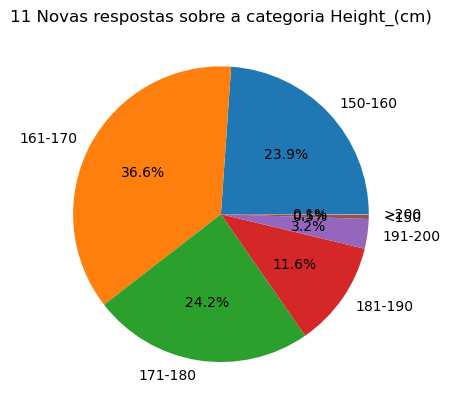

['101-120' '121-140' '40-60' '61-80' '81-100' '<40' '>140']
[206, 62, 173, 595, 482, 4, 22]


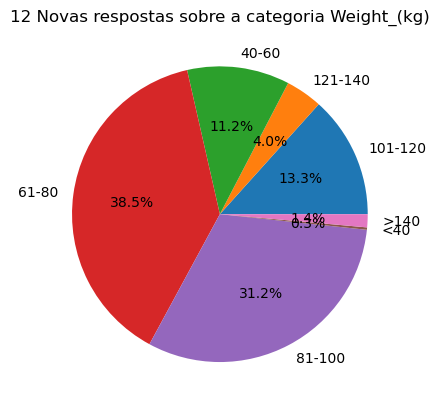

['gorda' 'magra' 'normal' 'obesa']
[126, 136, 1262, 20]


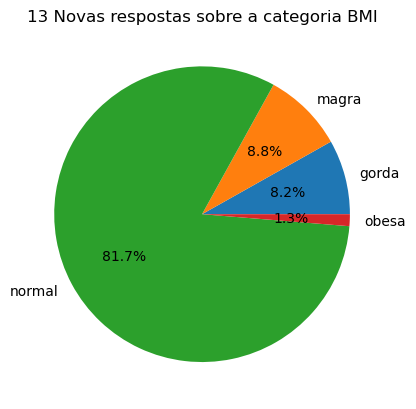

['bastante' 'medio' 'muito' 'nada' 'pouco']
[66, 137, 55, 1028, 258]


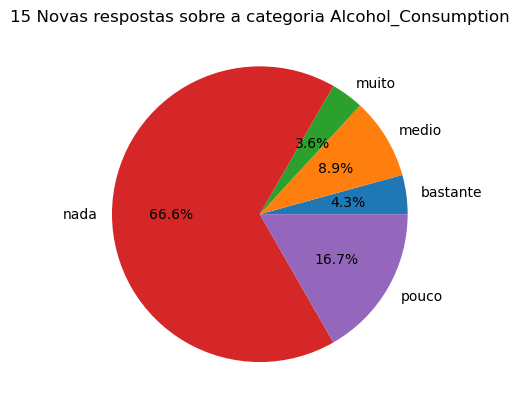

['bastante' 'medio' 'muito' 'muito pouco' 'nada' 'pouco']
[74, 601, 149, 386, 45, 289]


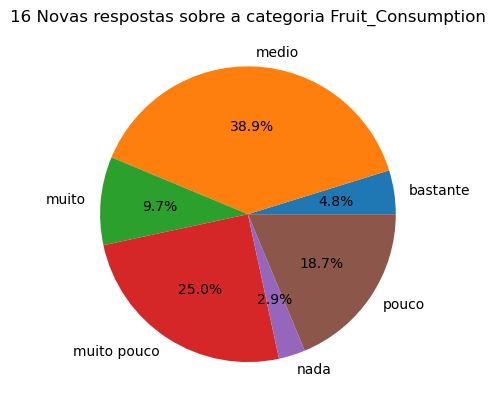

[' muito' 'medio' 'muito pouco' 'nada' 'pouco']
[35, 294, 700, 131, 384]


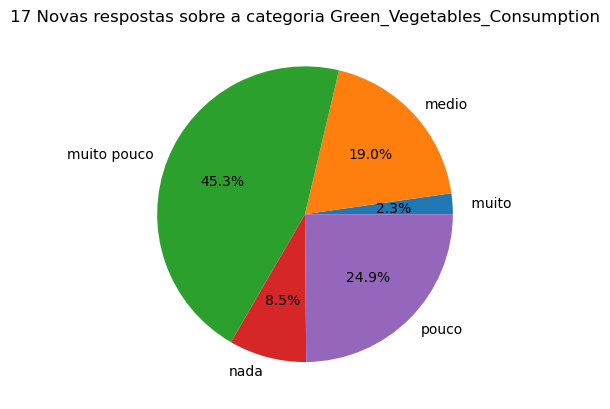

['bastante' 'medio' 'muito' 'nada' 'pouco']
[162, 247, 137, 276, 722]


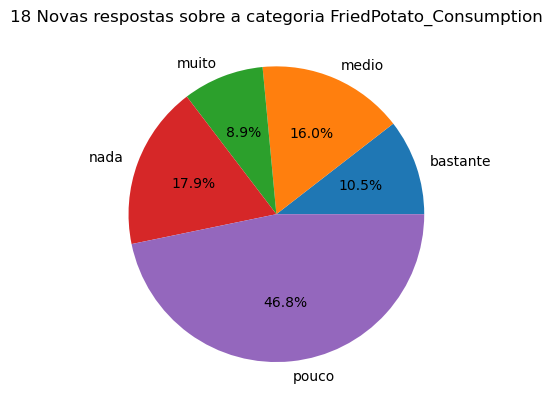

[array([3, 4, 4, ..., 3, 2, 2]), array([2, 4, 4, ..., 4, 4, 4]), array([0, 0, 1, ..., 0, 1, 1]), array([0, 1, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 1, 0, 0]), array([0, 2, 2, ..., 0, 0, 0]), array([1, 0, 0, ..., 1, 0, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([10, 10,  8, ..., 10,  7,  7]), array([150., 165., 163., ..., 191., 175., 185.]), array([32.66, 77.11, 88.45, ..., 81.65, 77.11, 88.45]), array([14.54, 28.29, 33.47, ..., 22.5 , 25.1 , 25.73]), array([1, 0, 0, ..., 1, 1, 0]), array([0., 0., 4., ..., 0., 3., 2.]), array([30., 30., 12., ...,  4., 90., 12.]), array([16.,  0.,  3., ...,  2., 30.,  4.]), array([12.,  4., 16., ...,  2.,  8., 12.])]
19


In [130]:

# DATA DISCRETIZATION - Vicente

# as comidas e bebidas para - nada muito_pouco pouco medio muito bastante
# altura - >100, 100-110, 111-120, 121-130, 131-140, 141-150, 151-160, 161-170, 171-180, 181-190, 191-200, <200
# BMI -> muito magro, magro normal, gordo, obeso, obesidade morbida
# peso -> data['bins'] = pd.cut(data['values'], bins=5, labels=['Low', 'Medium', 'High'])

def data_discretization(dataset):
    if isinstance(dataset, pd.DataFrame):
        dataset = dataset.to_numpy()
    dataset = dataset.T
    dataset.tolist()

    """
    Discretiza atributos numéricos do dataset em intervalos categóricos.

    Esta função processa colunas específicas do dataset para substituir valores numéricos
    por rótulos categóricos com base em limites definidos. Por exemplo:
    - Altura é agrupada em intervalos como "<150", "150-160", etc.
    - Peso é agrupado em intervalos como "<40", "40-60", etc.
    - IMC é categorizado em "magra", "normal", "gorda" ou "obesa".
    - Consumo de álcool, frutas, vegetais e batata frita é categorizado em níveis
    descritivos como "nada", "pouco", "medio", "muito" ou "bastante".

    O dataset processado é retornado com os valores numéricos substituídos por rótulos
    categóricos, tornando-o mais adequado para análises baseadas em categorias.
    """

    print(dataset[11][0:20])
    for i in [11, 12, 13, 15, 16, 17, 18]:
        dataset[i] = list(map(float, dataset[i]))
    print(dataset[11][0:20])


    #ALTURA
    for i in range(len(dataset[11])):
        if dataset[11][i] < 150: # +1.5m
            dataset[11][i] = "<150"
        elif dataset[11][i] >= 150 and dataset[11][i] <=160: # entre 1.5 e 1.6 m
            dataset[11][i] = "150-160"
        elif dataset[11][i] > 160 and dataset[11][i] <=170: # entre 1.6 e 1.7 m
            dataset[11][i] = "161-170"
        elif dataset[11][i] > 170 and dataset[11][i] <=180: # entre 1.7 e 1.8 m
            dataset[11][i] = "171-180"
        elif dataset[11][i] > 180 and dataset[11][i] <=190: # entre 1.8 e 1.9 m
            dataset[11][i] = "181-190"
        elif dataset[11][i] > 190 and dataset[11][i] <=200: # entre 1.9 e 2.0 m
            dataset[11][i] = "191-200"
        else: # +2.0m
            dataset[11][i] = ">200"
    
    #PESO
    for i in range(len(dataset[12])):
        if dataset[12][i] < 40: # -40kg
            dataset[12][i] = "<40"
        elif dataset[12][i] >= 40 and dataset[12][i] <=60: # entre 40 a 60 kg
            dataset[12][i] = "40-60"
        elif dataset[12][i] > 60 and dataset[12][i] <=80: # entre 60 a 80 kg
            dataset[12][i] = "61-80"
        elif dataset[12][i] > 80 and dataset[12][i] <=100: # entre 80 a 100 kg
            dataset[12][i] = "81-100"
        elif dataset[12][i] > 100 and dataset[12][i] <=120: # entre 100 a 120 kg
            dataset[12][i] = "101-120"
        elif dataset[12][i] > 120 and dataset[12][i] <=140: # entre 120 a 140 kg
            dataset[12][i] = "121-140"
        else: # +140kg
            dataset[12][i] = ">140" 

    #BMI
    for i in range(len(dataset[13])):
        bmi = 10 + (dataset[13][i] / 100) * (50-10) # meter a percentagem do dataset em categorias tabeladas do BMI
        if bmi < 18.5:
            dataset[13][i] = "magra"
        elif bmi >= 18.5 and bmi <= 24.9:
            dataset[13][i] = "normal"
        elif bmi >= 25 and bmi <= 29.9:
            dataset[13][i] = "gorda"
        else:
            dataset[13][i] = "obesa"
        
    #ALCOOL
    for i in range(len(dataset[15])):
        if dataset[15][i] == 0: # 0 - nada
            dataset[15][i] = "nada"
        elif dataset[15][i]>0 and dataset[15][i] <= 4: # 1x por semana - pouco
            dataset[15][i] = "pouco"
        elif dataset[15][i]>4 and dataset[15][i] <=12: #2/3x por semana - medio
            dataset[15][i] = "medio"
        elif dataset[15][i] > 12 and dataset[15][i] <= 20: # 4/5x por semana - muito
            dataset[15][i] = "muito"
        else: # +5x por semana - bastante
            dataset[15][i] = "bastante"

    #FRUTA
    for i in range(len(dataset[16])):
        if dataset[16][i] == 0: # 0 - nada
            dataset[16][i] = "nada"
        elif dataset[16][i] >0 and dataset[16][i] <9: # 1/2x por semana - muito pouco
            dataset[16][i] = "muito pouco"
        elif dataset[16][i] >=9 and dataset[16][i] <17: # 3/4x por semana - pouco
            dataset[16][i] = "pouco"
        elif dataset[16][i] >=17 and dataset[16][i] <31: # 5x por semana a 1x por dia - medio
            dataset[16][i] = "medio"
        elif dataset[16][i] >=31 and dataset[16][i] <61: # 1/2x por dia - muito
            dataset[16][i] = "muito"
        else: # +2x por dia - bastante
            dataset[16][i] = "bastante"

    #VEGETAIS
    for i in range(len(dataset[17])):
        if dataset[17][i] == 0: # 0 nada
            dataset[17][i] = "nada"
        elif dataset[17][i] >0 and dataset[17][i] <9: # 1/2x por semana - muito pouco
            dataset[17][i] ="muito pouco"
        elif dataset[17][i] >=9 and dataset[17][i] <17: # 3/4x por semana - pouco
            dataset[17][i] = "pouco"
        elif dataset[17][i] >=17 and dataset[17][i] <31: # 5x por semana a 1x por dia - medio
            dataset[17][i] = "medio"
        else: # +1x por dia - muito
            dataset[17][i] = " muito"

    #BATATA FRITA
    for i in range(len(dataset[18])):
        if dataset[18][i] == 0: # 0 - nada
            dataset[18][i] = "nada"
        elif dataset[18][i]> 0 and dataset[18][i] <5: #1x por semana - pouco
            dataset[18][i] = "pouco"
        elif dataset[18][i] >=5 and dataset[18][i] <9: # 2x por semana - medio
            dataset[18][i] = "medio"
        elif dataset[18][i] >=9 and dataset[18][i] <13: # 3x por semana - muito
            dataset[18][i] = "muito"
        else: # +3x por semana - bastante
            dataset[18][i] = "bastante"

    return dataset

copia2 = numpy_arrays_dataset.copy()

#testes3 = data_discretization(testes2) # dataset com Nones, substituidos por mais frequente, com data discretization

testes4 = data_discretization(copia2) # dataset com data discretization
#''' graficos
print(testes4[11][0:50])
print(len(testes4[11]))

testes4 = np.array(testes4)

for i in [11,12,13,15,16,17,18]:
    unicos = np.unique(testes4[i])
    valores = [np.count_nonzero(testes4[i]==x) for x in unicos]
    
    print(unicos)
    print(valores)

    plt.title(str(i)+" Novas respostas sobre a categoria "+str(categorias[i]))
    plt.pie(valores,labels=unicos,autopct='%1.1f%%')
    plt.show()



# DATA REDUCTION - Vicente

#print(dataset_num) dups
#print(len(dataset_num))
#print(len(np.unique(dataset_num,axis=0)))

# fazer modelos pra ver atributos que posso remover (0, 1 e 6 principalmente)






# meter os dados para numeros

testes4 = np.array(testes4)
dataset_num = []

# meter o datset para numeros para dar com os modelos
for col in numpy_arrays_dataset_transposed:
    try:
        dataset_num.append(col.astype(float))
    except ValueError:
        le = LabelEncoder()
        encoded_col = le.fit_transform(col)
        dataset_num.append(encoded_col)

print(dataset_num)
print(len(dataset_num))
dataset_num = np.array(dataset_num).T # dataset com as repostas normais como está no csv

In [131]:
def normalise_dataset(dataset):
    # todo
    return dataset

In [132]:
# Data reduction (Vicente)

# Discretization (Vicente)
discretized_dataset = data_discretization(pandas_frame_dataset.copy()) # TODO, deve retornar um panda dataframe # Aplica discretização aos dados para categorizá-los

# Normalization (Jonnas)
normalised_dataset = normalise_dataset(pandas_frame_dataset.copy()) # normalisa os valores

[150.0 165.0 163.0 180.0 191.0 183.0 175.0 165.0 163.0 163.0 160.0 175.0
 168.0 178.0 152.0 163.0 183.0 168.0 178.0 163.0]
[150.0 165.0 163.0 180.0 191.0 183.0 175.0 165.0 163.0 163.0 160.0 175.0
 168.0 178.0 152.0 163.0 183.0 168.0 178.0 163.0]


### 4. Modeling

- 4.1. Select modeling techniques - os algoritmos que o stor pede no enunciado
- 4.2. Generate test design - dependendo do modelo ter diferentes valores de sets de train, teste e validation
- 4.3. Build model - implementar os modelos
- 4.4. Assess model - interpretar os resultados dos modelos e comprara-los e testalos entre eles para ver qual/quais são os melhores

### Supervised Learning

In [133]:
def decision_trees(dataset):
    # todo
    return dataset

def multi_layer_perceptron(dataset):
    # todo
    return dataset

def k_nn(dataset):
    # todo
    return dataset

In [134]:
# olha para a Ficha 4, para como fizeste a função plot_performance(str_sizes, num_trials, performance_func), para saber o que retornar.

decision_trees(pandas_frame_dataset.copy())

multi_layer_perceptron(pandas_frame_dataset.copy())

k_nn(pandas_frame_dataset.copy())

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539,Very Good,Within the past 5 years,Yes,No,No,No,No,No,No,Male,25-29,183.0,91.17,27.26,No,0.0,4.0,0.0,20.0
1540,Good,Within the past year,Yes,No,No,No,No,No,Yes,Female,50-54,163.0,69.85,26.43,No,5.0,30.0,20.0,4.0
1541,Poor,Within the past year,No,No,No,No,Yes,No,Yes,Male,70-74,191.0,81.65,22.50,Yes,0.0,4.0,2.0,2.0
1542,Good,Within the past year,Yes,No,No,No,No,No,No,Male,55-59,175.0,77.11,25.10,Yes,3.0,90.0,30.0,8.0


#### Unsupervised Learning

categorias ['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']
[[ 3.  2.  0. ... 30. 16. 12.]
 [ 4.  4.  0. ... 30.  0.  4.]
 [ 4.  4.  1. ... 12.  3. 16.]
 ...
 [ 3.  4.  0. ...  4.  2.  2.]
 [ 2.  4.  1. ... 90. 30.  8.]
 [ 2.  4.  1. ... 12.  4. 12.]]
1544
1544
1544


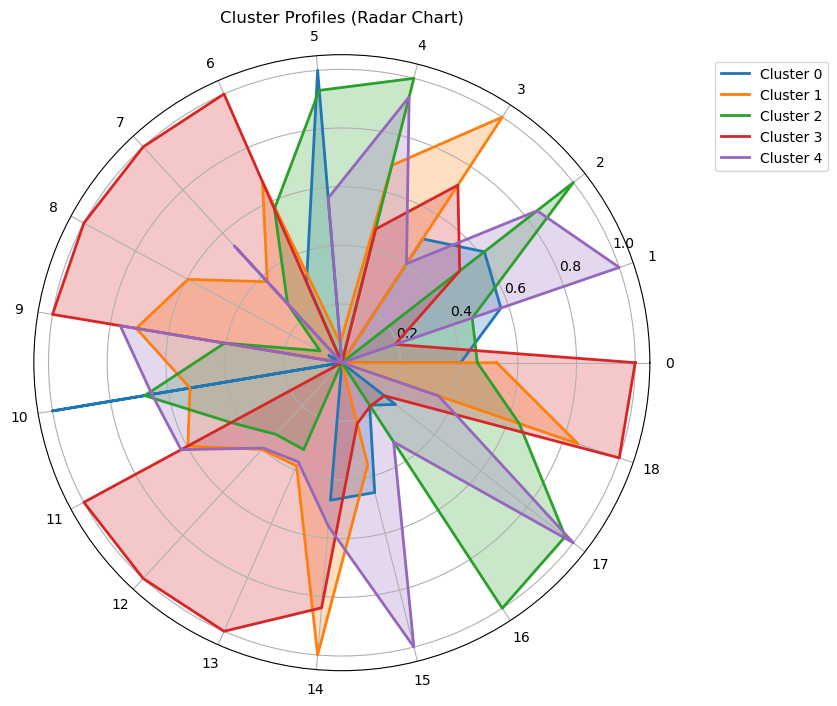

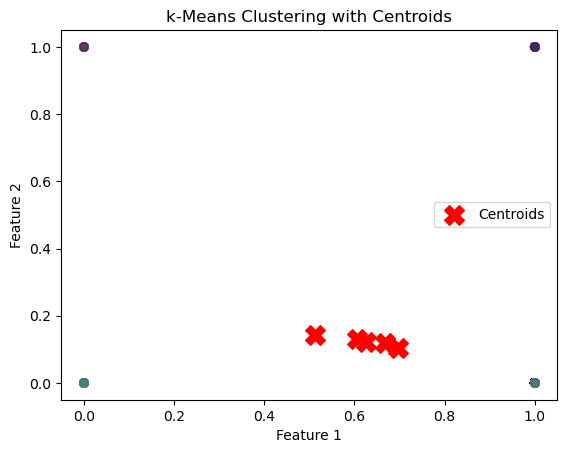

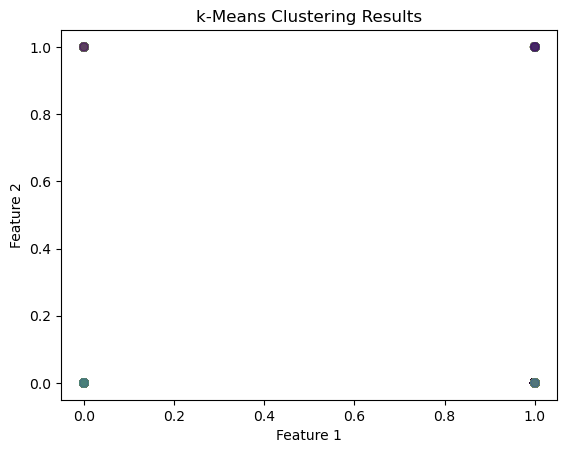

/tmp/ipykernel_41828/342001568.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=data_with_clusters, palette='viridis')


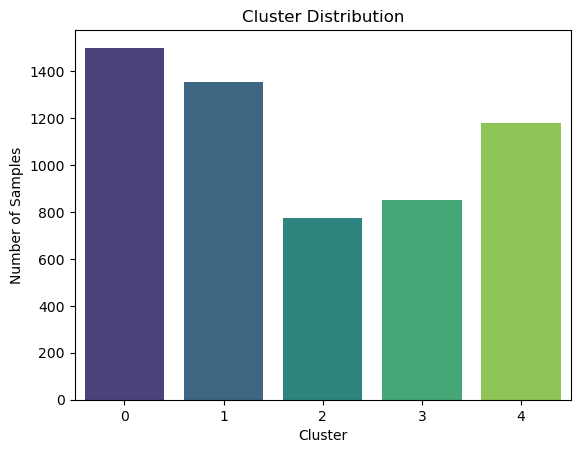

[0 1]
Counter({0: 1350, 1: 194})


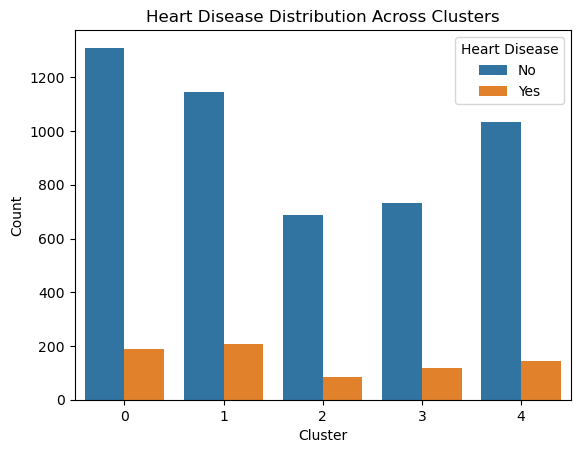

In [135]:
										#-----------------------------#
										#         4. Modeling         #
										#-----------------------------#

# UNSUPERVISED LEARNING - Vicente

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import seaborn as sns


print("categorias "+str(categorias))


print(dataset_num)
print(len(dataset_num))
print(len(np.unique(dataset_num,axis=0)))

#unicos = np.unique(dataset_num)
#valores = [np.count_nonzero(dataset_num==x) for x in unicos]
#print(unicos)
#print(valores)


kmeans = KMeans(n_clusters=5)
kmeans.fit(dataset_num)
cluster_labels = kmeans.labels_

print(len(cluster_labels))

# Step 3: Analyze clusters
# Add cluster labels to a DataFrame for analysis
data_with_clusters = pd.DataFrame(dataset_num)
data_with_clusters['Cluster'] = cluster_labels

#print(dataset_num)
#print(data_with_clusters)

# Display basic cluster statistics
#cluster_summary = data_with_clusters.groupby('Cluster').mean()
#print("Cluster Summary:")
#print(cluster_summary)

# Step 4: Visualize results
# Plot first two features for visualization (or use PCA for dimensionality reduction)



from math import pi

# Compute mean values for each feature in each cluster
cluster_profiles = data_with_clusters.groupby('Cluster').mean()

# Radar chart requires normalizing the data
cluster_profiles_normalized = (cluster_profiles - cluster_profiles.min()) / (cluster_profiles.max() - cluster_profiles.min())

# Create radar chart
categories = cluster_profiles_normalized.columns
num_clusters = cluster_profiles_normalized.shape[0]
angles = np.linspace(0, 2 * pi, len(categories), endpoint=False).tolist()
angles += angles[:1]  # Close the circle

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'polar': True})
for i in range(num_clusters):
    values = cluster_profiles_normalized.iloc[i].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, label=f"Cluster {i}", linewidth=2)
    ax.fill(angles, values, alpha=0.25)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.title("Cluster Profiles (Radar Chart)")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()


# Extract cluster centroids
centroids = kmeans.cluster_centers_

# Scatter plot with centroids
plt.scatter(dataset_num[:, 2], dataset_num[:, 3], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.scatter(centroids[:, 2], centroids[:, 3], c='red', marker='X', s=200, label='Centroids')
plt.title("k-Means Clustering with Centroids")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


plt.scatter(dataset_num[:, 2], dataset_num[:, 3], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.title("k-Means Clustering Results")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


sns.countplot(x='Cluster', data=data_with_clusters, palette='viridis')
plt.title("Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Samples")
plt.show()


#print(data_with_clusters['Cluster'])


# Assuming 'Heart_Disease' is the third column (index 2) in numpy_arrays_dataset_transposed.T
heart_disease_column = testes4.T[:, 3]  # Extract the column
# Convert 'Yes' to 1 and 'No' to 0
heart_disease_column_numeric = np.where(heart_disease_column == 'Yes', 1, 0)
#print(len(data_with_clusters.T))  # Should match len(numpy_arrays_dataset_transposed.T)
#print(len(heart_disease_column_numeric))  # Should match len(numpy_arrays_dataset_transposed.T)
# Add heart disease column to the DataFrame with clusters
data_with_clusters['Heart Disease'] = heart_disease_column_numeric

print(np.unique(data_with_clusters['Heart Disease']))

print(Counter(data_with_clusters['Heart Disease']))
#print(len(data_with_clusters))  # Should match len(numpy_arrays_dataset_transposed.T)
#print(data_with_clusters[0])
#print(len(heart_disease_column_numeric))  # Should match len(numpy_arrays_dataset_transposed.T)


# Create a count plot to show heart disease distribution across clusters
sns.countplot(x='Cluster', hue='Heart Disease', data=data_with_clusters)
plt.title("Heart Disease Distribution Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="Heart Disease", labels=["No", "Yes"])
plt.show()



### 5. Evaluation

- 5.1. Evaluate results - ver que modelos devemos usar e quais melhor correspondem com o business criteria
- 5.2. Review process - fazer uma revisão critica ao trabalho feito
- 5.3. Determine next steps - determnar se esta bom para o deploymente, se é preciso melhorar um pouco mais ou expandir o projeto // ns bem como fazer isto neste trabalho

In [136]:
										#-----------------------------#
										#        5. Evaluation        #
										#-----------------------------#

